In [1]:
# ----------------------------------------------------------------------------
# Author        :    Vasileios Perifanis
# Affiliation   :    Euclid team, Democritus University of Thrace, Dept. of Electrical & Computer Engineering
# Created Date  :    03/2022
# version       :    1.0
# ---------------------------------------------------------------------------

In [2]:
import numpy as np # linear algebra
import pandas as pd # data analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing

import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("datasets/titanic_train.csv", header=0) # read csv

data['Initial']=0
for i in data:
    data['Initial']=data.Name.str.extract('([A-Za-z]+)\.') #extract the Salutations

# Assigning the NaN Values the mean ages
data.loc[(data.Age.isnull())&(data.Initial=='Mr'),'Age']=33
data.loc[(data.Age.isnull())&(data.Initial=='Mrs'),'Age']=36
data.loc[(data.Age.isnull())&(data.Initial=='Master'),'Age']=5
data.loc[(data.Age.isnull())&(data.Initial=='Miss'),'Age']=22
data.loc[(data.Age.isnull())&(data.Initial=='Other'),'Age']=46

data['Embarked'].fillna('S',inplace=True)

data['Age_band']=0
data.loc[data['Age']<=16,'Age_band']=0
data.loc[(data['Age']>16)&(data['Age']<=32),'Age_band']=1
data.loc[(data['Age']>32)&(data['Age']<=48),'Age_band']=2
data.loc[(data['Age']>48)&(data['Age']<=64),'Age_band']=3
data.loc[data['Age']>64,'Age_band']=4

data['Family_Size']=0
data['Family_Size']=data['Parch']+data['SibSp']#family size
data['Alone']=0
data.loc[data.Family_Size==0,'Alone']=1#Alone

data['Fare_Range']=pd.qcut(data['Fare'],5)
data['Fare_cat']=0
data.loc[data['Fare']<=7.91,'Fare_cat']=0
data.loc[(data['Fare']>7.91)&(data['Fare']<=14.454),'Fare_cat']=1
data.loc[(data['Fare']>14.454)&(data['Fare']<=31),'Fare_cat']=2
data.loc[(data['Fare']>31)&(data['Fare']<=513),'Fare_cat']=3

data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

data.drop(['Name','Age','Ticket','Fare','Cabin','Initial','Fare_Range','PassengerId'],axis=1,inplace=True)

data.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Age_band,Family_Size,Alone,Fare_cat
0,0,3,0,1,0,0,1,1,0,0
1,1,1,1,1,0,1,2,1,0,3
2,1,3,1,0,0,0,1,0,1,1
3,1,1,1,1,0,0,2,1,0,3
4,0,3,0,0,0,0,2,0,1,1


In [4]:
def split(data):
    train,test=train_test_split(data,test_size=0.2,random_state=0,stratify=data['Survived'])
    return train, test

def to_numpy(train, test):
    train_X=train[train.columns[1:]].to_numpy()
    train_Y=train[train.columns[:1]].to_numpy().ravel()
    test_X=test[test.columns[1:]].to_numpy()
    test_Y=test[test.columns[:1]].to_numpy().ravel()
    return train_X, train_Y, test_X, test_Y

In [5]:
train, test = split(data)

In [6]:
train_X, train_Y, test_X, test_Y = to_numpy(train, test)
min_max_scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = min_max_scaler.transform(train_X)
test_X = min_max_scaler.transform(test_X)

In [7]:
class ClassifierDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return len(self.x_data)

In [8]:
def generate_dataset(train_x, train_y, batch_size, shuffle=True):
    dataset = ClassifierDataset(torch.from_numpy(train_x).float(), torch.from_numpy(train_y).long())
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)

    return loader

In [9]:
train_loader = generate_dataset(train_X, train_Y, batch_size=1024, shuffle=True)
test_loader = generate_dataset(test_X, test_Y, batch_size=1, shuffle=False)
print(f"Training set size: ({train_X.shape},{train_Y.shape}), Testing set size: ({train_Y.shape},{test_Y.shape})")

Training set size: ((712, 9),(712,)), Testing set size: ((712,),(179,))


In [10]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 256)
        self.layer2 = torch.nn.Linear(256, 128)
        self.out = torch.nn.Linear(128, num_classes)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.out(x)
        return x

In [11]:
num_classes = len(np.unique(train_Y))

In [12]:
model = MLP(train_X.shape[1], num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [13]:
def test(model, data, criterion):
    model.eval()
    y_true, y_pred = [], []
    loss, correct = 0., 0
    with torch.no_grad():
        for x, y in data:
            out = model(x)
            loss += criterion(out, y).item()
            pred = out.argmax(dim=1)

            # correct += int((pred == y).sum().item()) # torch accuracy method
            for i in range(len(pred)):
                y_pred.append(pred[i].item())
            for i in range(len(y)):
                y_true.append(y[i].item())
            
    loss = loss / len(data)
    #accuracy = correct / len(data.dataset) # torch accuracy method
    accuracy = accuracy_score(y_pred, y_true)
    precision = precision_score(y_pred, y_true)
    recall = recall_score(y_pred, y_true)
    f1 = f1_score(y_pred, y_true)

    return loss, accuracy, precision, recall, f1

def train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True):
    train_loss_history, train_acc_history = [], []  # track loss, accuracy
    test_loss_history, test_acc_history = [], []
    for epoch in range(1, epochs + 1):
        model.train()  # training mode
        for data, target in train_loader:
            optimizer.zero_grad()  # zero out gradients
            y_pred = model(data)  # forward propagation
            loss = criterion(y_pred, target)  # calculate loss
            loss.backward()  # backward pass, compute grads wrt to model parameters
            optimizer.step()  # update weights

        train_loss, train_acc, train_prec, train_rec, train_f = test(model, train_loader, criterion)  # test the model
        test_loss, test_acc, test_pred, test_rec, test_f = test(model, test_loader, criterion)

        train_acc_history.append(train_acc)  # keep metric history
        test_acc_history.append(test_acc)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)

        if epoch % log_interval == 0:  # log
            print(f"Epoch: [{epoch}/{epochs}]: Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1: {train_f:.4f}\n")
            print(f"\tLoss: {test_loss:.4f}, Eval Accuracy: {test_acc:.4f}, Eval Precision: {train_prec:.4f}, Eval Recall: {train_rec:.4f}, Eval F1: {train_f:.4f}")

    if plot:  # plot history
        plt.plot(train_acc_history, label="Train Acc")
        plt.plot(test_acc_history, label="Test Acc")
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(train_loss_history, label="Train Loss")
        plt.plot(test_loss_history, label="Test Loss")
        plt.legend()
        plt.show()
        plt.close()

    return model

In [14]:
epochs = 30

Epoch: [1/30]: Loss: 0.6707, Accuracy: 0.6166, Precision: 0.0000, Recall: 0.0000, F1: 0.0000

	Loss: 0.6718, Eval Accuracy: 0.6145, Eval Precision: 0.0000, Eval Recall: 0.0000, Eval F1: 0.0000
Epoch: [2/30]: Loss: 0.6522, Accuracy: 0.6236, Precision: 0.0183, Recall: 1.0000, F1: 0.0360

	Loss: 0.6546, Eval Accuracy: 0.6257, Eval Precision: 0.0183, Eval Recall: 1.0000, Eval F1: 0.0360
Epoch: [3/30]: Loss: 0.6346, Accuracy: 0.6784, Precision: 0.1648, Recall: 0.9783, F1: 0.2821

	Loss: 0.6385, Eval Accuracy: 0.6704, Eval Precision: 0.1648, Eval Recall: 0.9783, Eval F1: 0.2821
Epoch: [4/30]: Loss: 0.6179, Accuracy: 0.6812, Precision: 0.1722, Recall: 0.9792, F1: 0.2928

	Loss: 0.6233, Eval Accuracy: 0.6704, Eval Precision: 0.1722, Eval Recall: 0.9792, Eval F1: 0.2928
Epoch: [5/30]: Loss: 0.6021, Accuracy: 0.7107, Precision: 0.2491, Recall: 0.9855, F1: 0.3977

	Loss: 0.6091, Eval Accuracy: 0.6983, Eval Precision: 0.2491, Eval Recall: 0.9855, Eval F1: 0.3977
Epoch: [6/30]: Loss: 0.5871, Accura

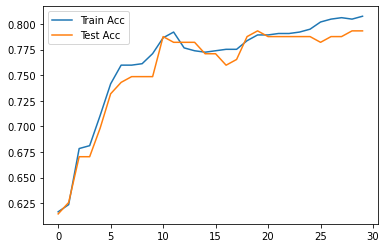

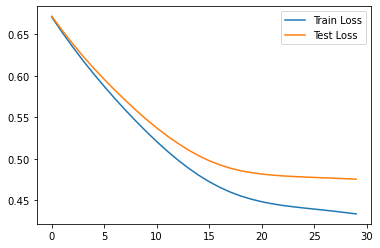

In [15]:
trained_model = train(model, train_loader, test_loader, optimizer, criterion, epochs, log_interval=1, plot=True)